0.016988277435302734


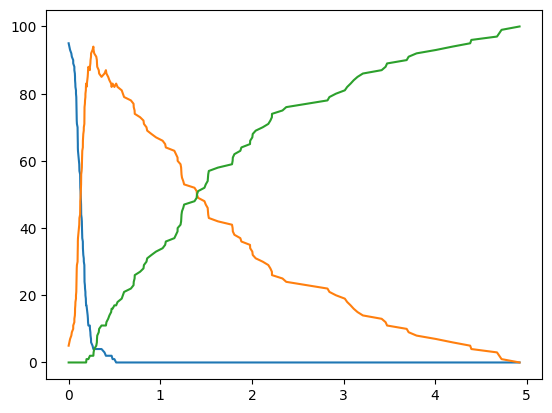

In [ ]:
from collections import defaultdict
import random as rd, numpy as np, networkx as nx, matplotlib.pyplot as plt

# Criando grafo
n_nodes = 100
prob = 6/n_nodes
G = nx.erdos_renyi_graph(n_nodes,prob)

# Construindo matriz de adjacencia
dic = nx.convert.to_dict_of_dicts(G)
sordic = sorted(dic.keys())
adj_mtz = {}
for i in sordic:
    adj_mtz.update({i:dic[i]})


import time
start = time.time()

# Vértices infectados e recuperados iniciais
k = round(n_nodes*0.05)  # K infectados
lst = list(np.arange(n_nodes))
initial_infecteds = rd.sample(lst, k=k) # K vértices aleatórios

initial_recovereds = []

# Tempo
tmin = 0
#tmax = 100
t = tmin

# Taxas
tau = 2
gamma = 0.8

# Listas para plot
I = [len(initial_infecteds)]
R = [len(initial_recovereds)]
S = [n_nodes-I[0]-R[0]]
times = [tmin]

# Crio um dicionário com o status 'S' e vou trocando os indices dos infectados para 'I' ou 'R'
status = defaultdict(lambda : 'S')
for node in initial_infecteds:
    status[node] = 'I'
#for node in initial_recovereds:
#    status[node] = 'R'

# Lista de infectados
infecteds = []

# Crio uma lista 2d, com cada termo referente a conexão (link) do infectado com o suscetícel (inf, sus)
IS_links = []

for node in initial_infecteds:

    # Para cada nó infectado adiciono ele na lista de infectados
    infecteds.append(node)

    # Se ele tem algum vizinho suscetível, crio um link entre ele e o suscetível.
    for nbr in list(adj_mtz[node]):  #must have this in a separate loop from assigning status
        if status[nbr] == 'S':
            IS_links.append((node, nbr))

# Crianto as taxas totais
total_recovery_rate = gamma*np.size(infecteds)

total_transmission_rate = tau*(np.size(IS_links)/2) # divido por 2 por causa que o np.size conta todos os termos (inf e sus)
                                                        # sendo que só preciso o número de conecções entre eles.
total_rate = total_recovery_rate + total_transmission_rate
delay = rd.expovariate(total_rate)
t += delay

while infecteds:

    # Processo de recuperação:
    if rd.random()<total_recovery_rate/total_rate:

        # Escolha sem peso de um infectado
        recovering_node = rd.choice(infecteds)
        infecteds.remove(recovering_node)
        status[recovering_node]='R'

        # Removo os links deste infectado com os suscetíveis que ele havia.
        for nbr in list(adj_mtz[recovering_node]):
            if status[nbr] == 'S':
                IS_links.remove((recovering_node, nbr))

        times.append(t)
        S.append(S[-1])
        I.append(I[-1]-1)
        R.append(R[-1]+1)

    # Infecção
    else:
        # Escolho uma conexão (link) aleatória entre um infectado e um suscetível
        transmitter, recipient = rd.choice(IS_links)
        status[recipient]='I'

        # Adiciono na lista de infectados o suscetível
        infecteds.append(recipient)

        # Crio os links deste novo infectado com os suscetíveis ao seu arredor.
        for nbr in list(adj_mtz[recipient]):

            if status[nbr] == 'S':
                IS_links.append((recipient, nbr))

            # Removo as conexões que haviam entre algum infectado e este vértice que era suscetível
            elif status[nbr]=='I' and nbr != recipient:
                IS_links.remove((nbr, recipient))

        times.append(t)
        S.append(S[-1]-1)
        I.append(I[-1]+1)
        R.append(R[-1])

    total_recovery_rate = gamma*np.size(infecteds)
    total_transmission_rate = tau*np.size(IS_links)

    total_rate = total_recovery_rate + total_transmission_rate

    if total_rate>0:
        delay = rd.expovariate(total_rate)
    else:
        delay = float('Inf')
    t += delay

stop = time.time()
print(stop - start)

plt.plot(times,S)
plt.plot(times,I)
plt.plot(times,R)